<a href="https://colab.research.google.com/github/CarlHad333/Non_Verbal_Behaviour/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing necessary packages

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#installing a package for text processing that's not available dy default on Colab
!pip install neattext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 1.3 MB/s eta 0:00:00


In [ ]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import os
import re
import neattext.functions as nfx
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import torch
import torch
#from transformers import AutoTokenizer, AutoModel
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

#Visualizing the data

In [ ]:
root_path = '/content/gdrive/MyDrive/IEMOCAP_full_release_withoutVideos_sentenceOnly'

df = pd.read_csv(os.path.join(root_path, 'iemocap.csv'))

display(df.head())

,Unnamed: 0,session,method,gender,n_annotators,agreement,emotion,valence,activation,dominance,wav_path,MOCAP_rotated_path,MOCAP_head_path,MOCAP_hand_path,FA_ph_path,FA_st_path,FA_sy_path,FA_wd_path
0,0,1,script,F,3,3,neu,2.5,2.0,2.0,IEMOCAP_full_release/Session1/sentences/wav/Se...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...
1,1,1,script,F,3,2,fru,2.5,2.0,2.5,IEMOCAP_full_release/Session1/sentences/wav/Se...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...
2,2,1,script,F,0,0,xxx,2.0,2.0,2.5,IEMOCAP_full_release/Session1/sentences/wav/Se...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...
3,3,1,script,F,3,2,sur,2.5,3.0,3.0,IEMOCAP_full_release/Session1/sentences/wav/Se...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...
4,4,1,script,F,3,2,neu,2.0,3.0,3.0,IEMOCAP_full_release/Session1/sentences/wav/Se...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...


In [ ]:
df.columns

Index(['Unnamed: 0', 'session', 'method', 'gender', 'n_annotators',
       'agreement', 'emotion', 'valence', 'activation', 'dominance',
       'wav_path', 'MOCAP_rotated_path', 'MOCAP_head_path', 'MOCAP_hand_path',
       'FA_ph_path', 'FA_st_path', 'FA_sy_path', 'FA_wd_path'],
      dtype='object')

#Data prepping

The purpose of this part is to build a dataset of (text, associated emotions) pairs. This dataset will then be used for emotion recognition.

The function below takes as input the path to a .txt file, and returns a dictionary where the keys are the dialogue sentences, and the values and the emotions associated to the sentence.
\
**How it works:** \
- This is what a réplique in the transcript looks like : "*Ses01M_script02_1_M000 [003.3988-008.5500]: What time is it?  God, this is great, isn't it?  I can't believe it*."
- The fct takes this part '*Ses01M_script02_1_M000*', searches for the corresponding .wav file and the associated emotion (in the DataFrame df)
- It then adds the sentence "*What time is it?  God, this is great, isn't it?  I can't believe it.*" as key, and the value is the emotion found thanks to df.

**NB :** Only data where at least 2 annotators agree are added to our dictionnary

##Creating a dataframe for text

In [ ]:
def create_emotion_dictionary(txt_file):

    # The dictionnary that'll store (sentence: emotion)
    emotion_dict = {}
    #Reading the .txt file
    with open(txt_file, 'r') as file:
        for line in file:
            # Split the line based on ']:'
            parts = line.split(']:', 1)

            # Check if the line has the expected format (to deal with M: F: unidentified speakers)
            if len(parts) == 2:
                # Extract the replique ID from the line (to look for corresponding .wav file)
                replique_id = parts[0].split(' ')[0].strip()
                # Extract the sentence from the line
                sentence = parts[1].strip()

                # pattern to match the .wav file name
                pattern = replique_id.replace('[', '').replace(']', '') + r'.wav'

                # Find the corresponding row in df
                row = df[df['wav_path'].str.contains(pattern)]
                # Check if the row is found in the dataframe
                if not row.empty:
                    # Get the emotion if at least 2 annotators agree on it
                    emotion = row['emotion'].iloc[0]
                    agreement = row['agreement'].iloc[0]
                    if emotion != 'xxx' and agreement >=2:
                    # Add the sentence and emotion to the dictionary
                      emotion_dict[sentence] = emotion
    return emotion_dict

In [ ]:
session_names = ['Session1', 'Session2', 'Session3', 'Session4', 'Session5']
#Function to process all text files in a directory
def process_text_files_in_session(session_directory):
    emotion_dict_all = {}
    for root, dirs, files in os.walk(session_directory):
        for file in files:
            if file.endswith('.txt'):
                file_path = os.path.join(root, file)
                emotion_dict = create_emotion_dictionary(file_path)
                emotion_dict_all.update(emotion_dict)
    return emotion_dict_all

root_path = '/content/gdrive/MyDrive/IEMOCAP_full_release_withoutVideos_sentenceOnly'
#process_text_files_in_session(root_path  + '/IEMOCAP_full_release/Session1/dialog/transcriptions')

In [ ]:
# Function to process all sessions
def process_all_sessions(root_path):
    all_emotion_dict = {}
    for session_name in session_names:
        session_directory = os.path.join(root_path, session_name, 'dialog', 'transcriptions')
        session_emotion_dict = process_text_files_in_session(session_directory)
        all_emotion_dict[session_name] = session_emotion_dict
    return all_emotion_dict

In [ ]:
# Example
root_path = '/content/gdrive/MyDrive/IEMOCAP_full_release_withoutVideos_sentenceOnly/IEMOCAP_full_release'
#Dictionnary whose keys are sentences, and whose values are associated emotions
all_sessions_emotion_dict = process_all_sessions(root_path)

In [ ]:
session_dfs = []
for session, data in all_sessions_emotion_dict.items():
    # to get session nb (from 'Session1' for instance)
    session_number = session.replace('Session', '')  # Extract session number
    text_data = pd.DataFrame.from_dict(data, orient='index').reset_index()
    text_data.columns = ['sentence', 'emotion']
    text_data['Session'] = session_number  # Add session column
    text_data = text_data[['Session', 'sentence', 'emotion']]  # Reorder columns
    session_dfs.append(text_data)
# Concatenate all session DataFrames into one DataFrame
final_text_data = pd.concat(session_dfs, ignore_index=True)

In [ ]:
final_text_data.head()

,Session,sentence,emotion
0,1,You okay?,neu
1,1,"Yeah, I'm just-- yeah",sad
2,1,"Just kind of feel numb, you know.",sad
3,1,What's happened?,neu
4,1,You didn't even hear?,sad
5,1,[BREATHING] Umm.,sad
6,1,God I've told this story so many times. Umm.,sad


In [ ]:
#Cleaning our text
final_text_data['Clean_Text'] = final_text_data['sentence'].apply(nfx.remove_userhandles)
final_text_data['Clean_Text'] = final_text_data['sentence'].apply(nfx.remove_stopwords)

In [ ]:
final_text_data.head()

,Session,sentence,emotion,Clean_Text
0,1,You okay?,neu,okay?
1,1,"Yeah, I'm just-- yeah",sad,"Yeah, I'm just-- yeah"
2,1,"Just kind of feel numb, you know.",sad,"kind feel numb, know."
3,1,What's happened?,neu,What's happened?
4,1,You didn't even hear?,sad,hear?


In [ ]:
final_text_data.emotion.value_counts()

fru    1716
neu    1531
ang     999
exc     986
sad     958
hap     550
sur      81
fea      35
oth       3
dis       2
Name: emotion, dtype: int64

Not very balanced ...

[Git repo on text emotion recognition](https://github.com/SannketNikam/Emotion-Detection-in-Text/blob/main/notebooks/Emotion%20Detection%20in%20Text.ipynb) that inspired the processing below


In [ ]:
final_text_data

,Session,sentence,emotion,Clean_Text
0,1,You okay?,neu,okay?
1,1,"Yeah, I'm just-- yeah",sad,"Yeah, I'm just-- yeah"
2,1,"Just kind of feel numb, you know.",sad,"kind feel numb, know."
3,1,What's happened?,neu,What's happened?
4,1,You didn't even hear?,sad,hear?
...,...,...,...,...
6856,5,I don't know. I think this is a pretty good s...,hap,"know. think pretty good spot. mean, look view ..."
6857,5,"Yes, I did notice that. It does look really b...",hap,"Yes, notice that. look beautiful water. Big ol..."
6858,5,"Oh, well look what we've got here.",hap,"Oh, look we've got here."
6859,5,"Well, it isn't champagne.",hap,"Well, champagne."


##Balancing the dataset

- We'll only use 4 emotions : hap, sad, ang, neu
- Emotions 'exc' and 'hap' will be merged together

In [ ]:
selected_emotions = ['neu', 'ang', 'exc', 'sad', 'hap']
final_text_data_filtered = final_text_data[final_text_data['emotion'].isin(selected_emotions)].copy()

# Replace 'exc' with 'hap'
final_text_data_filtered.loc[final_text_data_filtered['emotion'] == 'exc', 'emotion'] = 'hap'

balanced_data = final_text_data_filtered.groupby('emotion').head(963)
LE = LabelEncoder()
balanced_data['label'] = LE.fit_transform(balanced_data['emotion'])
# Display the value counts
print(balanced_data['emotion'].value_counts())

neu    963
ang    963
hap    963
sad    958
Name: emotion, dtype: int64


<ipython-input-19-701ca4328e70>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balanced_data['label'] = LE.fit_transform(balanced_data['emotion'])


In [ ]:
# Emotions & their encoded labels
emotion_label_mapping = dict(zip(LE.classes_, LE.transform(LE.classes_)))
for emotion, label in emotion_label_mapping.items():
    print(f"Emotion: {emotion} - Label: {label}")

Emotion: ang - Label: 0
Emotion: hap - Label: 1
Emotion: neu - Label: 2
Emotion: sad - Label: 3


In [ ]:
balanced_data.head()

,Session,sentence,emotion,Clean_Text,label
0,1,You okay?,neu,okay?,2
1,1,"Yeah, I'm just-- yeah",sad,"Yeah, I'm just-- yeah",3
2,1,"Just kind of feel numb, you know.",sad,"kind feel numb, know.",3
3,1,What's happened?,neu,What's happened?,2
4,1,You didn't even hear?,sad,hear?,3


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(balanced_data['Clean_Text'], balanced_data['label'], test_size=0.2, random_state=42)

#Models

## First attempt
- Feature extraction : CountVectorizer
- Classifier : Logistic regression

In [ ]:
pipe_lr = Pipeline(steps=[('cv',CountVectorizer()),('lr',LogisticRegression(max_iter = 500))])
pipe_lr.fit(X_train,Y_train)
print('Accuracy: ')
pipe_lr.score(X_test,Y_test)

Accuracy: 


0.6116883116883117

###Confusion matrix

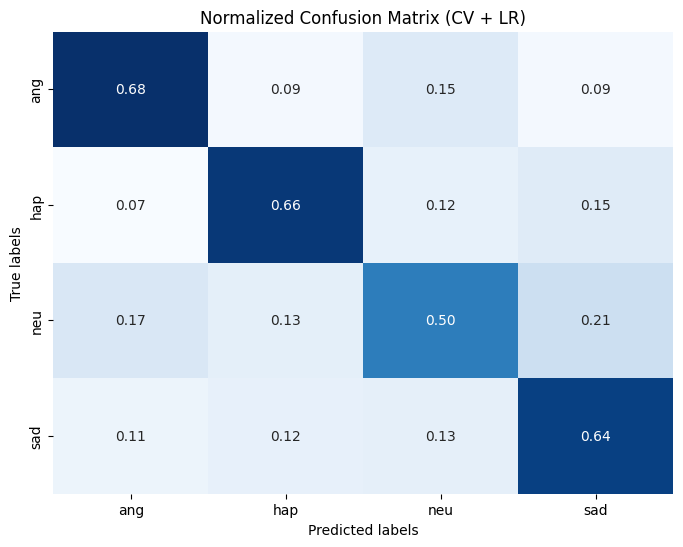

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define emotion class names
emotion_classes = ['ang', 'hap', 'neu', 'sad']

# Assuming you have already defined conf_matrix

# Normalize the confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap using Seaborn with class names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues', cbar=False, xticklabels=emotion_classes, yticklabels=emotion_classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix (CV + LR)')
plt.show()


##2nd attempt
- Feature extraction : TF-IDF vectorizer
- Classifier : Logistic regression

In [ ]:
pipe_lr_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter=1000))
])

pipe_lr_tfidf.fit(X_train, Y_train)

accuracy = pipe_lr_tfidf.score(X_test, Y_test)
print("Accuracy:", accuracy)

Accuracy: 0.6155844155844156


###Confusion matrix

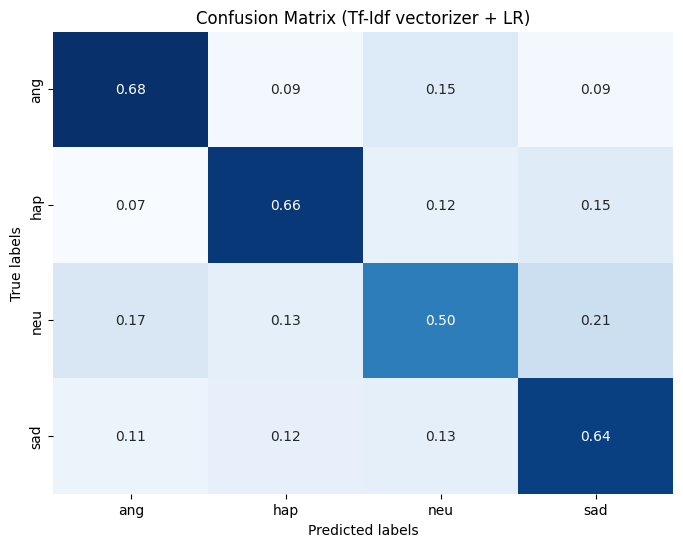

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Predictions on the test set
predicted_labels = pipe_lr_tfidf.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(Y_test, predicted_labels)

# Normalize the confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
#Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues', cbar=False, xticklabels=emotion_classes, yticklabels=emotion_classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Tf-Idf vectorizer + LR)')
plt.show()


##3rd attempt
- Feature extraction : CountVectorizer
- Classifier : XGB Classifier

In [ ]:
pipe_xgb_cv = Pipeline(steps=[('cv', CountVectorizer()), ('xgb', XGBClassifier())])
pipe_xgb_cv.fit(X_train,Y_train)
print('Accuracy: ')
pipe_xgb_cv.score(X_test,Y_test)

Accuracy: 


0.6012987012987013

##4th attempt
- Feature extraction : TF-IDF vectorizer
- Classifier : XGB Classifier

In [ ]:

pipe_xgb_tfidf = Pipeline(steps=[ ('tfidf', TfidfVectorizer()), ('xgb', XGBClassifier())])
pipe_xgb_tfidf.fit(X_train,Y_train)
print('Accuracy: ')
pipe_xgb_tfidf.score(X_test,Y_test)

Accuracy: 


0.5883116883116883

#Conclusion
- Feature extractor : TF-IDF
- Classifier : Logistic regression
This combo gave the best results so far